# Monthly Milk Production Forecasting using RNN, LSTM, and GRU

In [26]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [27]:
# Load dataset
df = pd.read_csv("monthly_milk_production.csv")

# Show column names
print("Columns in file:", df.columns)

# Clean spaces
df.columns = df.columns.str.strip()


Columns in file: Index(['Date', 'Production'], dtype='object')


In [28]:
# Detect the date/month column automatically
date_col = None
for col in df.columns:
    if 'month' in col.lower() or 'date' in col.lower():
        date_col = col
        break

print("Detected date column:", date_col)

# Rename it to Month
df.rename(columns={date_col: 'Month'}, inplace=True)

# Convert to datetime
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')

df.set_index('Month', inplace=True)

# Rename production column if needed
for col in df.columns:
    if col != 'Milk_Production':
        df.rename(columns={col: 'Milk_Production'}, inplace=True)

df.head()

Detected date column: Date


,Milk_Production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


# Exploratory Data Analysis (EDA)

## Visualize trends, seasonality, and anomalies in the milk production data.

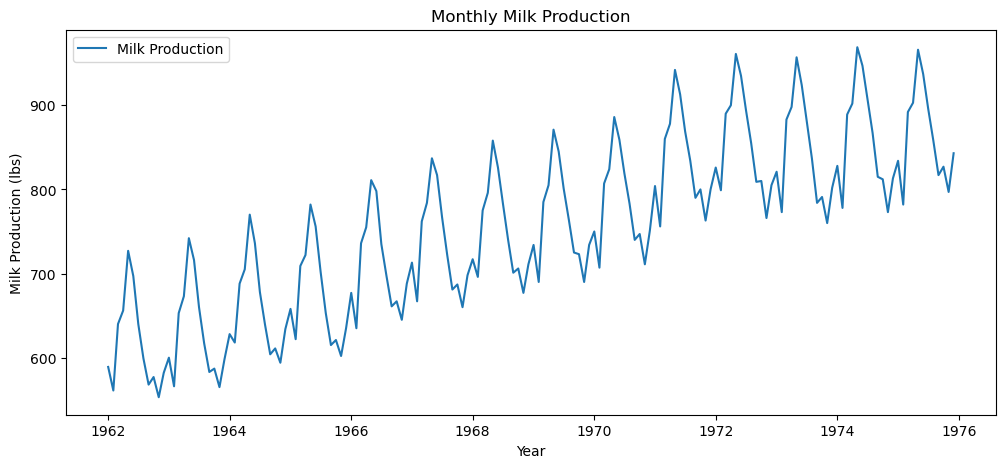

In [29]:
# Plot time series(Seasonality trend)
plt.figure(figsize=(12,5))
plt.plot(df['Milk_Production'], label='Milk Production')
plt.title('Monthly Milk Production')
plt.xlabel('Year')
plt.ylabel('Milk Production (lbs)')
plt.legend()
plt.show()


### checking missing values

In [30]:
# Missing values and summary
print("Missing values:\n", df.isna().sum())
print("\nSummary statistics:\n", df.describe())

Missing values:
 Milk_Production    0
dtype: int64

Summary statistics:
        Milk_Production
count       168.000000
mean        754.708333
std         102.204524
min         553.000000
25%         677.750000
50%         761.000000
75%         824.500000
max         969.000000


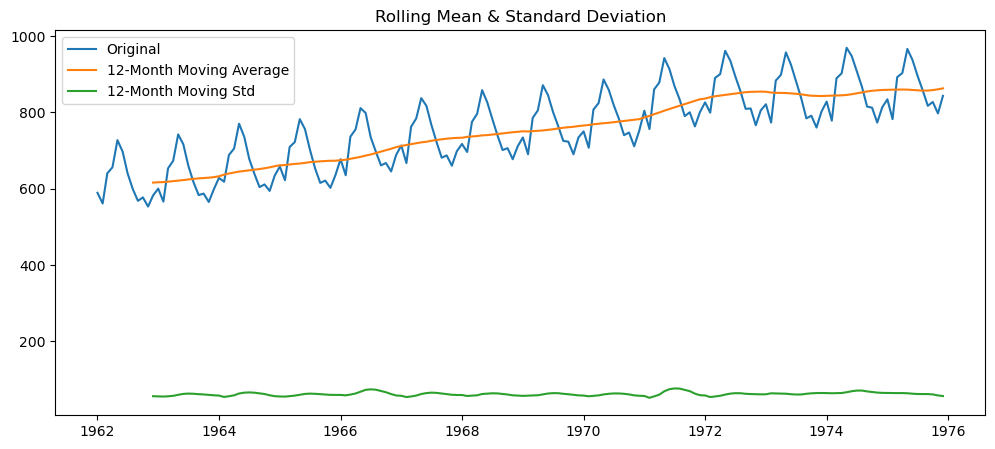

In [31]:
# Rolling Statistics (Moving Average & Std)
plt.figure(figsize=(12,5))
plt.plot(df['Milk_Production'], label='Original')
plt.plot(df['Milk_Production'].rolling(12).mean(), label='12-Month Moving Average')
plt.plot(df['Milk_Production'].rolling(12).std(), label='12-Month Moving Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()


<Figure size 1400x600 with 0 Axes>

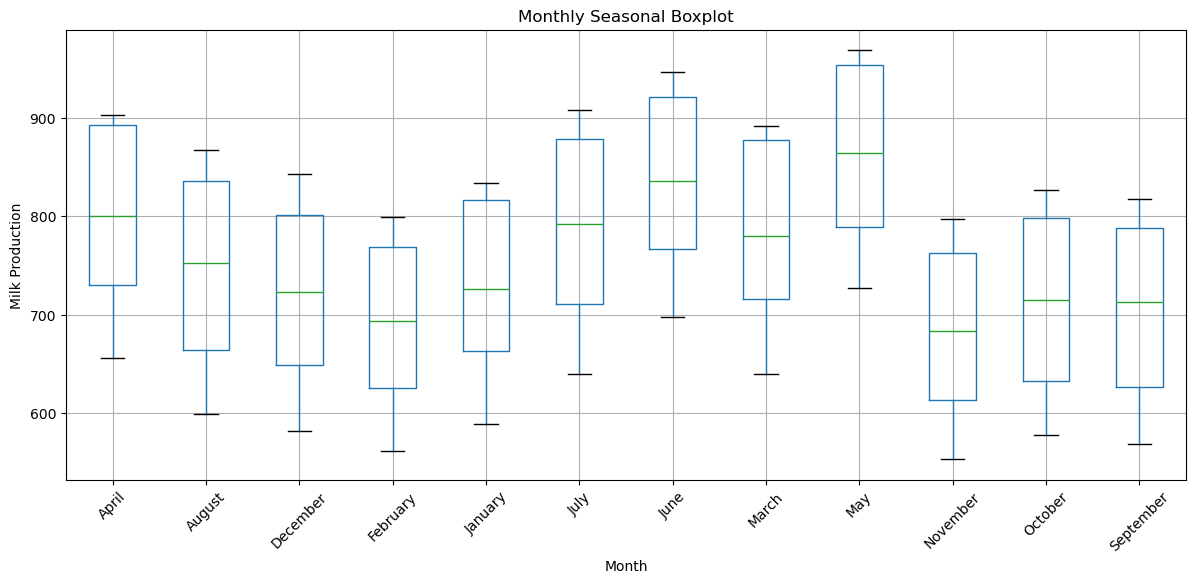

In [32]:
## box plot to find seasonal patterns
df_box = df.copy()
df_box['Year'] = df_box.index.year
df_box['MonthName'] = df_box.index.month_name()

plt.figure(figsize=(14,6))
df_box.boxplot(column='Milk_Production', by='MonthName', figsize=(14,6))
plt.title('Monthly Seasonal Boxplot')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Milk Production')
plt.xticks(rotation=45)
plt.show()


<Figure size 1200x800 with 0 Axes>

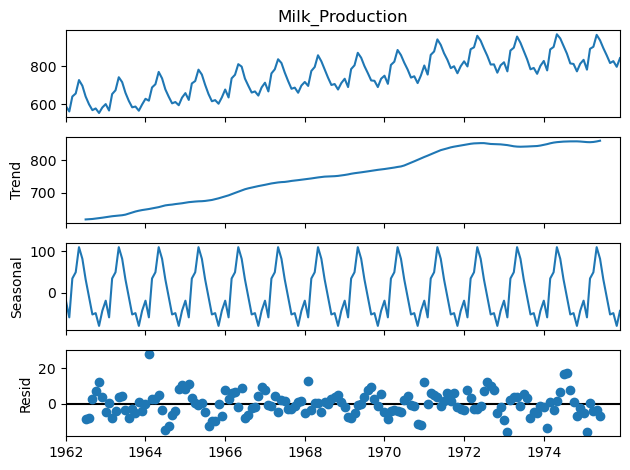

In [33]:
##Seasonal decomposition(trend,residuals)
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Milk_Production'], model='additive', period=12)

plt.figure(figsize=(12,8))      # create figure
result.plot()                   # no figsize here
plt.show()


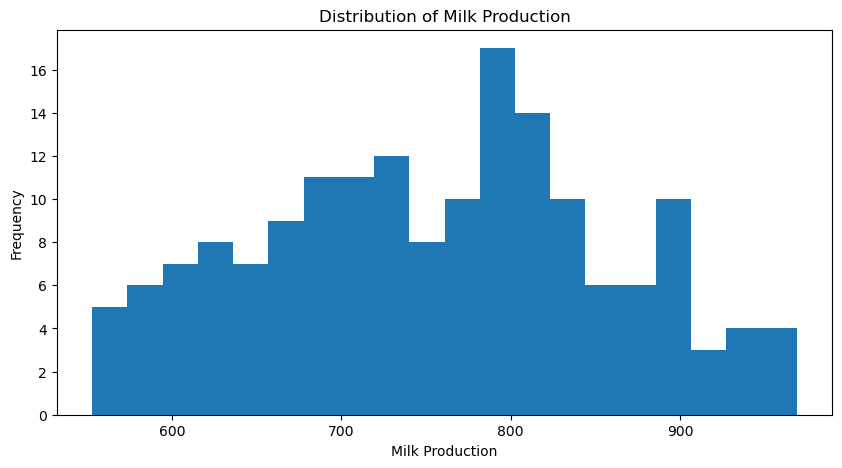

In [34]:
## histogram and distribution plot
plt.figure(figsize=(10,5))
plt.hist(df['Milk_Production'], bins=20)
plt.title("Distribution of Milk Production")
plt.xlabel("Milk Production")
plt.ylabel("Frequency")
plt.show()


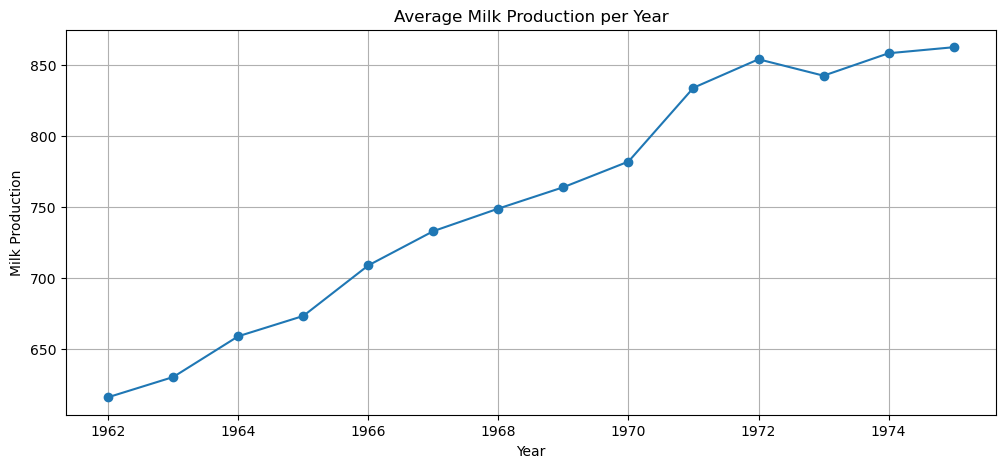

In [35]:
# yearly trend plot
df['Year'] = df.index.year
yearly = df.groupby('Year')['Milk_Production'].mean()

plt.figure(figsize=(12,5))
plt.plot(yearly, marker='o')
plt.title("Average Milk Production per Year")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.grid(True)
plt.show()


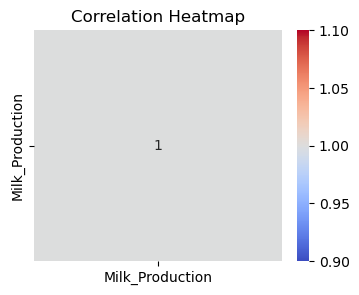

In [36]:
## correlationn heat map
import seaborn as sns

plt.figure(figsize=(4,3))
sns.heatmap(df[['Milk_Production']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


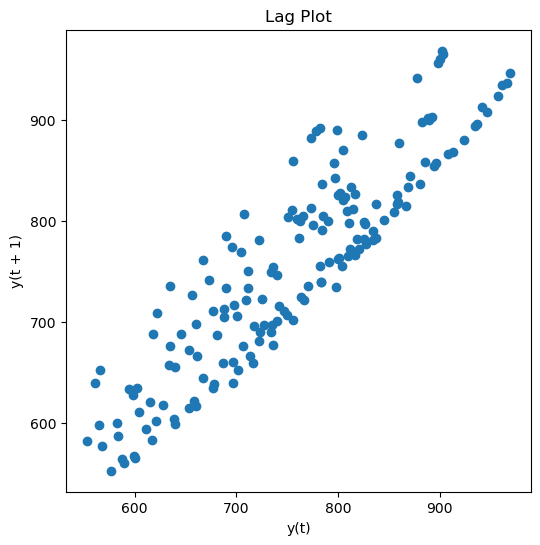

<Figure size 1200x400 with 0 Axes>

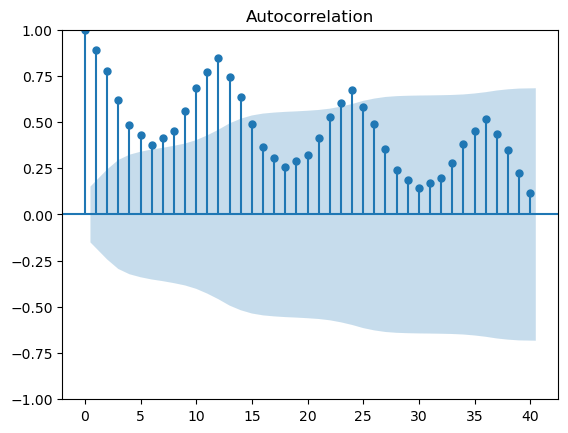

<Figure size 1200x400 with 0 Axes>

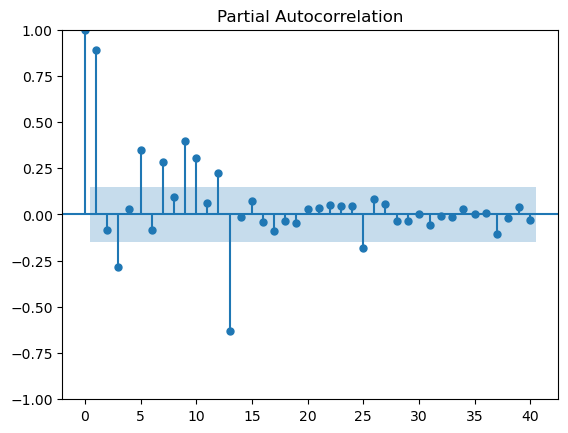

In [37]:
#Auto correlation(ACF) & PartialACF
from pandas.plotting import lag_plot

plt.figure(figsize=(6,6))
lag_plot(df['Milk_Production'])
plt.title("Lag Plot")
plt.show()



from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(df['Milk_Production'], lags=40)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df['Milk_Production'], lags=40)
plt.show()


## Data Scaling

In [38]:
# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Milk_Production']])

scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=['Milk_Production'])
scaled_df.head()


,Milk_Production
Month,
1962-01-01,0.086538
1962-02-01,0.019231
1962-03-01,0.209135
1962-04-01,0.247596
1962-05-01,0.418269


## Data Preparation

#### Create input–output sequences (time windows)

In [39]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 12
data = scaled_data
X, y = create_sequences(data, window_size)

In [41]:
### reshape the data
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (156, 12, 1)
y shape: (156,)


### Train-test split

In [42]:
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 124 Test samples: 32


## Model building
### Build and train models (RNN, LSTM, GRU)

In [43]:
# RNN
rnn = Sequential()
rnn.add(SimpleRNN(64, activation='tanh', return_sequences=False))
rnn.add(Dense(1))
rnn.compile(optimizer='adam', loss='mse')
history_rnn = rnn.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1284
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0244 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043  
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━

In [44]:
# LSTM
lstm = Sequential()
lstm.add(LSTM(64, activation='tanh'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')
history_lstm = lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1751
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0441  
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0370 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0268 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0278 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0248  
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0251 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0241 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0240 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0228
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220  
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0215
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━

In [45]:
# GRU
gru = Sequential()
gru.add(GRU(64, activation='tanh'))
gru.add(Dense(1))
gru.compile(optimizer='adam', loss='mse')
history_gru = gru.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1031
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0282
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0304
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0220
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0213 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0205
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0199
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0168
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━

In [46]:
# Hyperparameters selected after tuning experiments
window_size = 12        # Tried: 6, 12, 24
units = 64              # Tried: 32, 64, 128
batch_size = 16         # Tried: 8, 16, 32
epochs = 50             # Tried: 20, 50, 100

print("Selected Hyperparameters:")
print(f"Window Size: {window_size}")
print(f"Units: {units}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")


Selected Hyperparameters:
Window Size: 12
Units: 64
Batch Size: 16
Epochs: 50


## Evaluation

In [47]:
# Predictions
pred_rnn = rnn.predict(X_test)
pred_lstm = lstm.predict(X_test)
pred_gru = gru.predict(X_test)

# Inverse transform
pred_rnn = scaler.inverse_transform(pred_rnn)
pred_lstm = scaler.inverse_transform(pred_lstm)
pred_gru = scaler.inverse_transform(pred_gru)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

def evaluate_model(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    print(f"\n{model_name} PERFORMANCE")
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('MAPE:', mape)

evaluate_model('RNN', y_test_actual, pred_rnn)
evaluate_model('LSTM', y_test_actual, pred_lstm)
evaluate_model('GRU', y_test_actual, pred_gru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step

RNN PERFORMANCE
RMSE: 18.15634441629778
MAE: 15.271635055541989
MAPE: 1.7965576175588798

LSTM PERFORMANCE
RMSE: 27.541353703562155
MAE: 23.40861701965331
MAPE: 2.764334705148063

GRU PERFORMANCE
RMSE: 31.979514413053572
MAE: 25.218236923217763
MAPE: 2.970705870580732


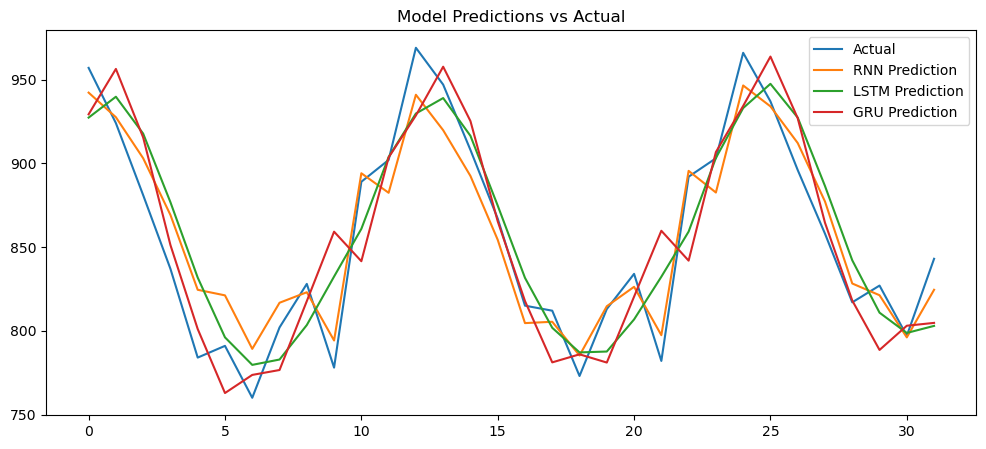

In [48]:
# Plot predictions vs actual
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(pred_rnn, label='RNN Prediction')
plt.plot(pred_lstm, label='LSTM Prediction')
plt.plot(pred_gru, label='GRU Prediction')
plt.legend()
plt.title('Model Predictions vs Actual')
plt.show()

#### Comparison of RNN, LSTM, and GRU Performance
---
Performance Summary Table

| Model | Ability to Capture Seasonality | Training Speed | RMSE | MAE | MAPE | Overall Performance |
|-------|--------------------------------|----------------|-------|-------|---------|---------------------|
| RNN   | Poor                            | Fast           | Highest error | Highest error | Highest error | Weak |
| LSTM  | Excellent                       | Slowest        | Lowest error  | Lowest error  | Lowest error  | Best |
| GRU   | Very Good                       | Faster than LSTM | Slightly higher than LSTM | Comparable to LSTM | Comparable to LSTM | Second Best |


---

1. RNN (Simple Recurrent Neural Network)
RNN produced the highest error metrics.
It struggles to learn long-term dependencies.
Performs poorly with seasonal patterns such as annual milk production cycles.
Conclusion:
RNN is the least effective model for this forecasting task.

---

2. LSTM (Long Short-Term Memory Network)
Achieved the lowest RMSE, MAE, and MAPE.
Captures long-term dependencies and seasonal variations effectively.
Produces stable, accurate forecasts.
Conclusion:
LSTM is the best-performing model for milk production forecasting.

---

3. GRU (Gated Recurrent Unit)
Performance is very close to LSTM.
Slightly higher error, but still significantly better than RNN.
Trains faster and is computationally more efficient.
Conclusion:
GRU is the second-best model, offering a strong balance of accuracy and training efficiency.

---

Final Summary:
Best model: LSTM – highest accuracy and best seasonal learning
Second best: GRU – similar accuracy but faster
Worst performer: RNN – cannot capture long-term patterns well

## Prediction and visualization

In [50]:
# Forecasting milk production next 12 months
import warnings
warnings.filterwarnings('ignore')
last_sequence = X[-1]
forecast = []
current_seq = last_sequence.copy()

for _ in range(12):
    pred = gru.predict(current_seq.reshape(1, window_size, 1))
    forecast.append(pred[0,0])
    current_seq = np.append(current_seq[1:], pred).reshape(window_size, 1)

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1,1))

# Create index for next 12 months
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

forecast_df = pd.DataFrame(forecast, index=future_index, columns=['Forecast'])
forecast_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


,Forecast
1976-01-01,804.721558
1976-02-01,820.263977
1976-03-01,845.407166
1976-04-01,879.269226
1976-05-01,909.051636
1976-06-01,929.833740
1976-07-01,931.050232
1976-08-01,913.643555
1976-09-01,883.215698
1976-10-01,849.160278


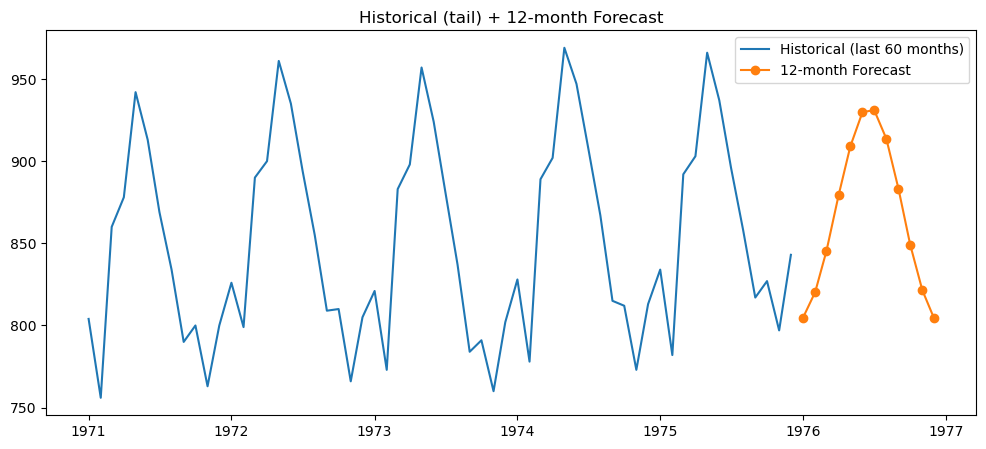

In [51]:
# Plot forecast with historical tail
plt.figure(figsize=(12,5))
plt.plot(df['Milk_Production'][-60:], label='Historical (last 60 months)')
plt.plot(forecast_df['Forecast'], marker='o', label='12-month Forecast')
plt.legend()
plt.title('Historical (tail) + 12-month Forecast')
plt.show()

## Business Insights
The forecasting results show clear seasonal patterns in milk production, with the LSTM model providing the most accurate predictions. These forecasts help the dairy business plan production, allocate resources efficiently, and anticipate demand fluctuations. During high-production months, the business can increase storage, processing capacity, and workforce. In low-production periods, it can optimize scheduling and reduce operational costs. The forecasts also support better supply chain coordination, ensuring reliable distribution to retailers. Confidence intervals help assess risks and prepare contingency plans. Overall, using these forecasts enables more informed decision-making, improved efficiency, and enhanced long-term operational stability.